# Импорт библиотек

In [1]:
from tqdm import tqdm
import os
import shutil
import torch
from torch.utils.data import DataLoader
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
from __future__ import print_function, division
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.onnx

%matplotlib inline
plt.ion()

# Функция загрузчика данных

Загрузчик данных с функцией разделения на трейн и валидацию.

In [2]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/idao_dataset/energy_train'

In [ ]:
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    test_transforms = transforms.Compose([transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=32)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=32)
    return trainloader, testloader

## Проверка

In [ ]:
train_loader, val_loader = load_split_train_test(data_dir, .2)
print(train_loader.dataset.classes)
print(val_loader.dataset.classes)
print(len(train_loader))
print(len(val_loader))

['1', '10', '20', '3', '30', '6']
['1', '10', '20', '3', '30', '6']
671
168


In [ ]:
ww = transforms.Compose([transforms.CenterCrop(150),
                         transforms.ToTensor(),
                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

qq = torch.utils.data.DataLoader(datasets.ImageFolder(data_dir, transform=ww),
                            batch_size=16)

features, target = next(iter(qq))

print(features.shape) 

torch.Size([16, 3, 150, 150])


## Визуализация

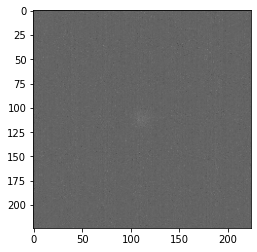

In [ ]:
X_batch, y_batch = next(iter(train_loader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

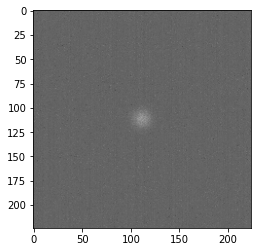

In [ ]:
X_batch, y_batch = next(iter(val_loader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

0it [00:00, ?it/s]

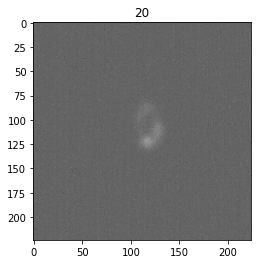

1it [00:00,  7.27it/s]

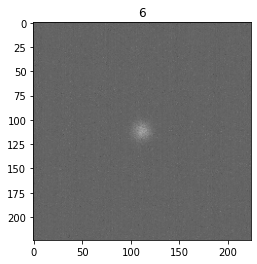

2it [00:00,  7.12it/s]

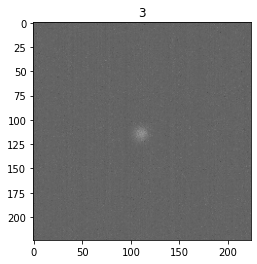

3it [00:00,  6.98it/s]

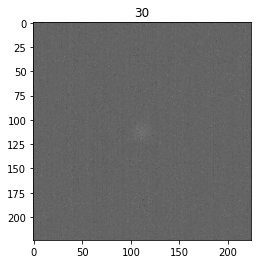

4it [00:00,  6.98it/s]

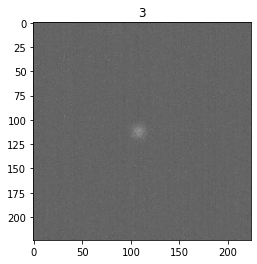

5it [00:00,  6.87it/s]

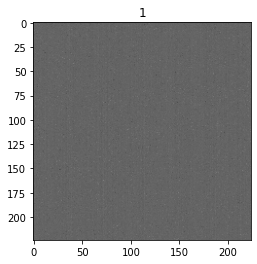

6it [00:00,  6.47it/s]

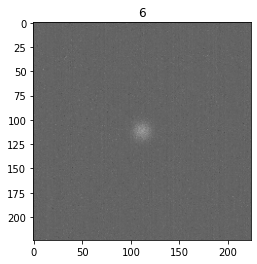

7it [00:01,  6.60it/s]

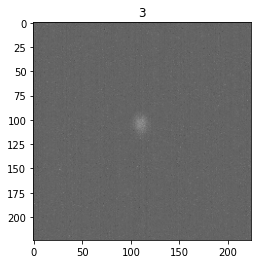

8it [00:01,  6.59it/s]

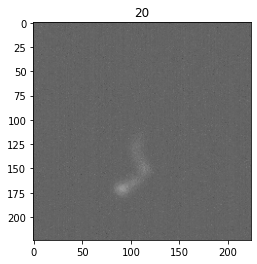

9it [00:01,  6.58it/s]

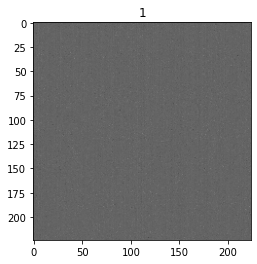

10it [00:01,  5.59it/s]

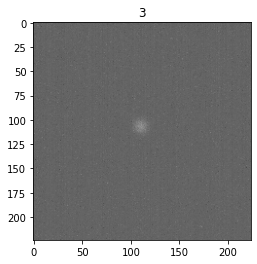

11it [00:01,  5.89it/s]

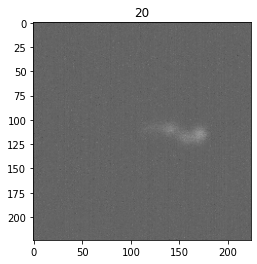

12it [00:01,  5.99it/s]

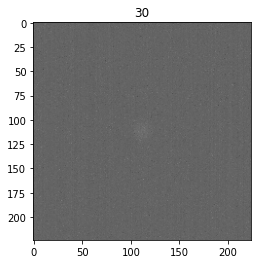

13it [00:02,  6.18it/s]

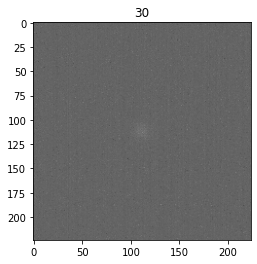

14it [00:02,  6.31it/s]

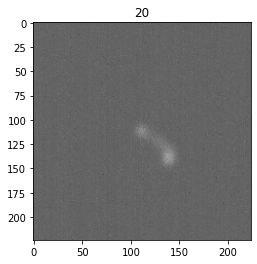

15it [00:02,  6.35it/s]

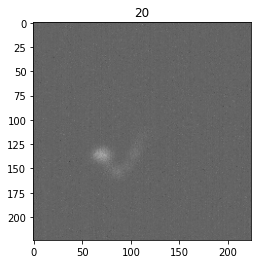

16it [00:02,  6.33it/s]


In [ ]:
class_names = ['1', '3', '6', '10', '20', '30']

def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_loader))

for x_item, y_item in tqdm(zip(X_batch, y_batch)):
    show_input(x_item, title=class_names[y_item])

# Модели

## Функция модели `create_nn_v1`

In [ ]:
def create_nn_v1(batch_size, 
              #dir,
              train_loader, 
              test_loader,
              learning_rate=0.01, epochs=10,
              log_interval=10):

    class ConvNet(nn.Module): 
        def __init__(self):
            super(ConvNet, self).__init__()
            self.c1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
            self.c2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
            self.c3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
            self.fc1 = nn.Linear(in_features=6272, out_features=512)
            self.fc2 = nn.Linear(in_features=512, out_features=256)
            self.fc3 = nn.Linear(in_features=256, out_features=412)
            self.fc4 = nn.Linear(in_features=412, out_features=6)
        
        def forward(self, x):
            x = F.relu(F.max_pool2d(self.c1(x), 3))
            x = F.relu(F.max_pool2d(self.c2(x), 3))
            x = F.relu(F.max_pool2d(self.c3(x), 3))
            x = x.view(x.size(0), -1)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc3(x))
            x = self.fc4(x)

            return F.log_softmax(x,  dim=1)

    net = ConvNet()
    print(net)

    # create a loss function
    criterion = nn.CrossEntropyLoss()
    # create a optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    total_step = len(train_loader)
    loss_list = []
    acc_list = []
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(train_loader):
            # Прямой запуск
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss_list.append(loss.item())

            # Обратное распространение и оптимизатор
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Отслеживание точности
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)

            if (i + 1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                      .format(epoch + 1, epochs, i + 1, total_step, loss.item(),
                              (correct / total) * 100))

    net.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Test Accuracy of the model on the test images: {} %'
              .format((correct / total) * 100))

In [ ]:
create_nn_v1(batch_size=32, train_loader=train_loader, test_loader=val_loader,
              learning_rate=0.01, epochs=5,
              log_interval=10)

ConvNet(
  (c1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (c2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (c3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=412, bias=True)
  (fc4): Linear(in_features=412, out_features=6, bias=True)
)
Epoch [1/5], Step [100/671], Loss: 1.7784, Accuracy: 31.25%
Epoch [1/5], Step [200/671], Loss: 1.7805, Accuracy: 25.00%
Epoch [1/5], Step [300/671], Loss: 1.7981, Accuracy: 18.75%
Epoch [1/5], Step [400/671], Loss: 1.7578, Accuracy: 31.25%
Epoch [1/5], Step [500/671], Loss: 1.8008, Accuracy: 6.25%
Epoch [1/5], Step [600/671], Loss: 1.7896, Accuracy: 18.75%
Epoch [2/5], Step [100/671], Loss: 1.8124, Accuracy: 6.25%
Epoch [2/5], Step [200/671], Loss: 1.7967, Accuracy: 12.50%
Epoch [2/5], Step [300/671], Loss: 1.7742, Accuracy: 25.00%
Epoch [2/5], Step [400/671], L

## Функция модели `create_nn_v2`

In [3]:
#Объявляю функцию загрузчика с аргументами Директория, Размер батча, Размер валидационной выборки
def load_split_train_test_v2(datadir, batch_size, valid_size = .2): 
    #Трансформации для обучающей выборки
    train_transforms = transforms.Compose([transforms.CenterCrop(224), 
                                           transforms.RandomHorizontalFlip(p=0.5),
                                           transforms.RandomVerticalFlip(p=0.5),
                                           transforms.RandomRotation(degrees=(45, 90)),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    #Трансформации для тестовой выборки
    test_transforms = transforms.Compose([transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    #Загрузчик для тренировочной выборки
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    #Загрузчик для тренировочной выборки
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    #Код для разделения на трейн и тест в указанном соотношении
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=batch_size)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=batch_size)
    return trainloader, testloader

In [4]:
#Получаю тренировочный и валидационный генераторы
train_loader, val_loader = load_split_train_test_v2(data_dir, 
                                                    batch_size=16,
                                                    valid_size = .2)
#Проверяю результаты работы генераторов
print(train_loader.dataset.classes)
print(val_loader.dataset.classes)
print(len(train_loader))
print(len(val_loader))

['1', '10', '20', '3', '30', '6']
['1', '10', '20', '3', '30', '6']
671
168


In [5]:
#Объявляю функцию для нейросети с аргументами Трей и тест загрузчиков,
#шагом обучения и количеством эпох
def create_nn_v2(train_loader,
                 test_loader,
                 learning_rate=0.01,
                 epochs=10
                 ):

    #Объявляю класс модели, определяю архитектуру
    class ConvNet(nn.Module): 
        def __init__(self):
            super(ConvNet, self).__init__()
            self.c1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
            self.c2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
            self.c3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
            self.fc1 = nn.Linear(in_features=6272, out_features=1024)
            self.fc2 = nn.Linear(in_features=1024, out_features=512)
            self.fc3 = nn.Linear(in_features=512, out_features=256)
            self.fc4 = nn.Linear(in_features=256, out_features=6)
        
        def forward(self, x):
            x = F.relu(F.max_pool2d(self.c1(x), 3))
            x = F.relu(F.max_pool2d(self.c2(x), 3))
            x = F.relu(F.max_pool2d(self.c3(x), 3))
            x = x.view(x.size(0), -1)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc3(x))
            x = self.fc4(x)

            return F.log_softmax(x,  dim=1)

    net = ConvNet()
    print(net)

    #Задаю функцию потерь
    criterion = nn.CrossEntropyLoss()
    #Задаю оптимизатор
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    total_step = len(train_loader)
    loss_list = []
    acc_list = []
    for epoch in range(epochs):
        for i, (images, labels) in tqdm(enumerate(train_loader)):
            #Прямой запуск
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss_list.append(loss.item())

            #Обратное распространение и оптимизатор
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #Отслеживание точности
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)

            if (i + 1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                      .format(epoch + 1, epochs, i + 1, total_step, loss.item(),
                              (correct / total) * 100))
    #Проверка на валидационной выборке
    net.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in tqdm(test_loader):
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Test Accuracy of the model on the test images: {} %'
              .format((correct / total) * 100))

In [6]:
%%time
#Запускаю функцию нейросети
create_nn_v2(train_loader=train_loader,
             test_loader=val_loader,
             learning_rate=0.01,
             epochs=5)

0it [00:00, ?it/s]

ConvNet(
  (c1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (c2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (c3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6272, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=6, bias=True)
)


100it [11:17,  6.58s/it]

Epoch [1/5], Step [100/671], Loss: 0.6069, Accuracy: 62.50%


200it [22:14,  6.50s/it]

Epoch [1/5], Step [200/671], Loss: 0.7599, Accuracy: 75.00%


300it [32:58,  6.53s/it]

Epoch [1/5], Step [300/671], Loss: 0.5374, Accuracy: 62.50%


400it [43:54,  6.44s/it]

Epoch [1/5], Step [400/671], Loss: 0.1602, Accuracy: 93.75%


500it [55:12,  6.41s/it]

Epoch [1/5], Step [500/671], Loss: 0.3909, Accuracy: 68.75%


600it [1:05:53,  6.53s/it]

Epoch [1/5], Step [600/671], Loss: 0.4841, Accuracy: 56.25%


671it [1:13:32,  6.58s/it]
100it [01:15,  1.29it/s]

Epoch [2/5], Step [100/671], Loss: 0.3887, Accuracy: 87.50%


200it [02:32,  1.34it/s]

Epoch [2/5], Step [200/671], Loss: 0.4170, Accuracy: 68.75%


300it [03:45,  1.37it/s]

Epoch [2/5], Step [300/671], Loss: 0.1315, Accuracy: 100.00%


400it [04:57,  1.39it/s]

Epoch [2/5], Step [400/671], Loss: 0.5204, Accuracy: 75.00%


500it [06:10,  1.39it/s]

Epoch [2/5], Step [500/671], Loss: 0.6841, Accuracy: 68.75%


600it [07:22,  1.41it/s]

Epoch [2/5], Step [600/671], Loss: 0.2790, Accuracy: 93.75%


671it [08:12,  1.36it/s]
100it [01:11,  1.41it/s]

Epoch [3/5], Step [100/671], Loss: 0.1898, Accuracy: 87.50%


200it [02:23,  1.39it/s]

Epoch [3/5], Step [200/671], Loss: 0.2068, Accuracy: 100.00%


300it [03:35,  1.34it/s]

Epoch [3/5], Step [300/671], Loss: 0.2683, Accuracy: 87.50%


400it [04:48,  1.36it/s]

Epoch [3/5], Step [400/671], Loss: 0.1390, Accuracy: 93.75%


500it [06:01,  1.38it/s]

Epoch [3/5], Step [500/671], Loss: 0.6307, Accuracy: 68.75%


600it [07:12,  1.38it/s]

Epoch [3/5], Step [600/671], Loss: 0.1026, Accuracy: 93.75%


671it [08:03,  1.39it/s]
100it [01:11,  1.38it/s]

Epoch [4/5], Step [100/671], Loss: 0.4477, Accuracy: 68.75%


200it [02:22,  1.41it/s]

Epoch [4/5], Step [200/671], Loss: 0.2125, Accuracy: 87.50%


300it [03:34,  1.38it/s]

Epoch [4/5], Step [300/671], Loss: 0.1891, Accuracy: 100.00%


400it [04:47,  1.39it/s]

Epoch [4/5], Step [400/671], Loss: 0.2118, Accuracy: 87.50%


500it [05:59,  1.36it/s]

Epoch [4/5], Step [500/671], Loss: 0.3366, Accuracy: 87.50%


600it [07:12,  1.33it/s]

Epoch [4/5], Step [600/671], Loss: 0.3712, Accuracy: 93.75%


671it [08:04,  1.39it/s]
100it [01:11,  1.41it/s]

Epoch [5/5], Step [100/671], Loss: 0.3608, Accuracy: 93.75%


200it [02:23,  1.41it/s]

Epoch [5/5], Step [200/671], Loss: 0.2939, Accuracy: 81.25%


300it [03:34,  1.37it/s]

Epoch [5/5], Step [300/671], Loss: 0.2317, Accuracy: 93.75%


400it [04:46,  1.40it/s]

Epoch [5/5], Step [400/671], Loss: 0.7391, Accuracy: 81.25%


500it [05:57,  1.39it/s]

Epoch [5/5], Step [500/671], Loss: 0.3502, Accuracy: 93.75%


600it [07:09,  1.41it/s]

Epoch [5/5], Step [600/671], Loss: 0.2174, Accuracy: 93.75%


671it [07:59,  1.40it/s]
100%|██████████| 168/168 [17:06<00:00,  6.11s/it]

Test Accuracy of the model on the test images: 92.27611940298507 %
CPU times: user 39min 15s, sys: 44.8 s, total: 40min
Wall time: 2h 2min 59s


# Черновики

In [ ]:
def create_nn(batch_size, 
              #dir,
              train_loader, 
              test_loader,
              learning_rate=0.01, epochs=10,
              log_interval=10):

    class ConvNet(nn.Module): 
        def __init__(self):
            super(ConvNet, self).__init__()
            self.c1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
            self.c2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
            self.c3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
            self.fc1 = nn.Linear(in_features=6272, out_features=512)
            self.fc2 = nn.Linear(in_features=512, out_features=256)
            self.fc3 = nn.Linear(in_features=256, out_features=412)
            self.fc4 = nn.Linear(in_features=412, out_features=6)
        
        def forward(self, x):
            x = F.relu(F.max_pool2d(self.c1(x), 3))
            x = F.relu(F.max_pool2d(self.c2(x), 3))
            x = F.relu(F.max_pool2d(self.c3(x), 3))
            x = x.view(x.size(0), -1)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc3(x))
            x = self.fc4(x)

            return F.log_softmax(x,  dim=1)

    net = ConvNet()
    print(net)

    # create a stochastic gradient descent optimizer
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    # create a loss function
    criterion = nn.NLLLoss()

    # run the main training loop
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = Variable(data), Variable(target)
            # resize data from (batch_size, 1, 28, 28) to (batch_size, 28*28)
            #data = data.view(batch_size, 150*150)
            #data = data.view(-1, 150*150)
            optimizer.zero_grad()
            net_out = net(data)
            loss = criterion(net_out, target)
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                           100. * batch_idx / len(train_loader), loss.item()))

    # run a test loop
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        #data = data.view(batch_size, 150*150)
        #data = data.view(-1, 150 * 150)
        net_out = net(data)
        # sum up batch loss
        test_loss += criterion(net_out, target).data.item()
        pred = net_out.data.max(1)[1]  # get the index of the max log-probability
        correct += pred.eq(target.data).sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


#if __name__ == "__main__":
#    run_opt = 2
#    if run_opt == 1:
#        simple_gradient()
#    elif run_opt == 2:
#        create_nn('batch_size', 'train_loader', 'test_loader')

In [ ]:
create_nn(batch_size=16, train_loader=train_loader, test_loader=val_loader,
              learning_rate=0.01, epochs=2,
              log_interval=10)

ConvNet(
  (c1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (c2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (c3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=412, bias=True)
  (fc4): Linear(in_features=412, out_features=6, bias=True)
)
Train Epoch: 0 [0/13404 (0%)]	Loss: 1.795762
Train Epoch: 0 [160/13404 (1%)]	Loss: 1.788725
Train Epoch: 0 [320/13404 (3%)]	Loss: 1.818620
Train Epoch: 0 [480/13404 (4%)]	Loss: 1.783009
Train Epoch: 0 [640/13404 (6%)]	Loss: 1.767075
Train Epoch: 0 [800/13404 (7%)]	Loss: 1.759646
Train Epoch: 0 [960/13404 (9%)]	Loss: 1.789608
Train Epoch: 0 [1120/13404 (10%)]	Loss: 1.805487
Train Epoch: 0 [1280/13404 (12%)]	Loss: 1.788997
Train Epoch: 0 [1440/13404 (13%)]	Loss: 1.770361
Train Epoch: 0 [1600/13404 (15%)]	Loss: 1.809474
Train Epoch: 0 [1760/13404 (16%)]	Loss: 1.807

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Test set: Average loss: 0.0024, Accuracy: 2559/13404 (19%)



In [ ]:
def create_nn(batch_size, 
              #dir,
              train_loader, 
              test_loader,
              learning_rate=0.01, epochs=10,
              log_interval=10):

    #train_loader = torch.utils.data.DataLoader(
    #    datasets.MNIST('../data', train=True, download=True,
    #                   transform=transforms.Compose([
    #                       transforms.ToTensor(),
    #                       transforms.Normalize((0.1307,), (0.3081,))
    #                   ])),
    #    batch_size=batch_size, shuffle=True)
    #test_loader = torch.utils.data.DataLoader(
    #    datasets.MNIST('../data', train=False, transform=transforms.Compose([
    #        transforms.ToTensor(),
    #        transforms.Normalize((0.1307,), (0.3081,))
    #    ])),
    #    batch_size=batch_size, shuffle=True)

    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(150 * 150, 200)
            self.fc2 = nn.Linear(200, 200)
            self.fc3 = nn.Linear(200, 6)

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return F.log_softmax(x)

    net = Net()
    print(net)

    # create a stochastic gradient descent optimizer
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    # create a loss function
    criterion = nn.NLLLoss()

    # run the main training loop
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = Variable(data), Variable(target)
            # resize data from (batch_size, 1, 28, 28) to (batch_size, 28*28)
            #data = data.view(batch_size, 150*150)
            data = data.view(-1, 150*150)
            optimizer.zero_grad()
            net_out = net(data)
            loss = criterion(net_out, target)
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                           100. * batch_idx / len(train_loader), loss.data[0]))

    # run a test loop
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        #data = data.view(batch_size, 150*150)
        data = data.view(-1, 150 * 150)
        net_out = net(data)
        # sum up batch loss
        test_loss += criterion(net_out, target).data[0]
        pred = net_out.data.max(1)[1]  # get the index of the max log-probability
        correct += pred.eq(target.data).sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


#if __name__ == "__main__":
#    run_opt = 2
#    if run_opt == 1:
#        simple_gradient()
#    elif run_opt == 2:
#        create_nn('batch_size', 'train_loader', 'test_loader')

In [ ]:
create_nn(batch_size=32, train_loader=train_loader, test_loader=val_loader,
              learning_rate=0.01, epochs=20,
              log_interval=10)

Net(
  (fc1): Linear(in_features=360000, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=6, bias=True)
)


RuntimeError: ignored

In [ ]:
class ConvNet(nn.Module): 
     def __init__(self): 
         super(ConvNet, self).__init__() 
         self.layer1 = nn.Sequential( nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2), 
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
         self.layer2 = nn.Sequential( nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2), 
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
         self.drop_out = nn.Dropout() 
         self.fc1 = nn.Linear(7 * 7 * 64, 1000) 
         self.fc2 = nn.Linear(1000, 10)

    def forward(self, x): 
        out = self.layer1(x) 
        out = self.layer2(out) 
        out = out.reshape(out.size(0), -1) 
        out = self.drop_out(out) 
        out = self.fc1(out) 
        out = self.fc2(out) 
        return out

In [ ]:
def create_nn(batch_size, 
              #dir,
              train_loader, 
              test_loader,
              learning_rate=0.01, epochs=10,
              log_interval=10):

    #train_loader = torch.utils.data.DataLoader(
    #    datasets.MNIST('../data', train=True, download=True,
    #                   transform=transforms.Compose([
    #                       transforms.ToTensor(),
    #                       transforms.Normalize((0.1307,), (0.3081,))
    #                   ])),
    #    batch_size=batch_size, shuffle=True)
    #test_loader = torch.utils.data.DataLoader(
    #    datasets.MNIST('../data', train=False, transform=transforms.Compose([
    #        transforms.ToTensor(),
    #        transforms.Normalize((0.1307,), (0.3081,))
    #    ])),
    #    batch_size=batch_size, shuffle=True)

    class ConvNet(nn.Module): 
        def __init__(self): 
            super(ConvNet, self).__init__() 
            self.layer1 = nn.Sequential(nn.Conv2d(3, 68, kernel_size=32, stride=2, padding=8), 
                nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
            #self.layer2 = nn.Sequential( nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2), 
            #    nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
            self.drop_out = nn.Dropout() 
            self.fc1 = nn.Linear(200, 34) 
            self.fc2 = nn.Linear(34, 6)

        def forward(self, x): 
            out = self.layer1(x) 
            #out = self.layer2(out) 
            #out = out.reshape(out.size(0), -1) 
            out = self.drop_out(out) 
            out = self.fc1(out) 
            out = self.fc2(out) 
            return F.log_softmax(out)

    net = ConvNet()
    print(net)

    # create a stochastic gradient descent optimizer
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    # create a loss function
    criterion = nn.NLLLoss()

    # run the main training loop
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = Variable(data), Variable(target)
            # resize data from (batch_size, 1, 28, 28) to (batch_size, 28*28)
            #data = data.view(batch_size, 150*150)
            #data = data.view(-1, 150*150)
            optimizer.zero_grad()
            net_out = net(data)
            loss = criterion(net_out, target)
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                           100. * batch_idx / len(train_loader), loss.data[0]))

    # run a test loop
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        #data = data.view(batch_size, 150*150)
        #data = data.view(-1, 150 * 150)
        net_out = net(data)
        # sum up batch loss
        test_loss += criterion(net_out, target).data[0]
        pred = net_out.data.max(1)[1]  # get the index of the max log-probability
        correct += pred.eq(target.data).sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


#if __name__ == "__main__":
#    run_opt = 2
#    if run_opt == 1:
#        simple_gradient()
#    elif run_opt == 2:
#        create_nn('batch_size', 'train_loader', 'test_loader')

In [ ]:
create_nn(batch_size=32, train_loader=train_loader, test_loader=val_loader,
              learning_rate=0.01, epochs=20,
              log_interval=10)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 68, kernel_size=(32, 32), stride=(2, 2), padding=(8, 8))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=200, out_features=34, bias=True)
  (fc2): Linear(in_features=34, out_features=6, bias=True)
)


RuntimeError: ignored

In [ ]:
class Net(nn.Module):
    def __init__(self):
       super(Net, self).__init__()
       self.fc1 = nn.Linear(150 * 150, 200)
       self.fc2 = nn.Linear(200, 200)
       self.fc3 = nn.Linear(200, 10)

    def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return F.log_softmax(x)

In [ ]:
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=22500, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
)


In [ ]:
# Осуществляем оптимизацию путем стохастического градиентного спуска
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
# Создаем функцию потерь
criterion = nn.NLLLoss()

In [ ]:
# запускаем главный тренировочный цикл
for epoch in range(epochs):
   for batch_idx, (data, target) in enumerate(train_loader):
       data, target = Variable(data), Variable(target)
# изменим размер с (batch_size, 1, 28, 28) на (batch_size, 28*28)
       data = data.view(-1, 28*28)
       optimizer.zero_grad()
       net_out = net(data)
       loss = criterion(net_out, target)
       loss.backward()
       optimizer.step()
       if batch_idx % log_interval == 0:
           print('Train Epoch: {} [{}/{} ({:.0f}%)]tLoss: {:.6f}'.format(
                   epoch, batch_idx * len(data), len(train_loader.dataset),
                          100. * batch_idx / len(train_loader), loss.data[0]))

In [ ]:
train_transforms = transforms.Compose([
    transforms.CenterCrop(150),
    transforms.GaussianBlur(kernel_size=5),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0, contrast=3, saturation=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/idao_dataset/energy_train', train_transforms)

In [ ]:
batch_size = 16
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


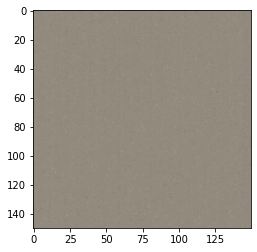

In [ ]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
0it [00:00, ?it/s]

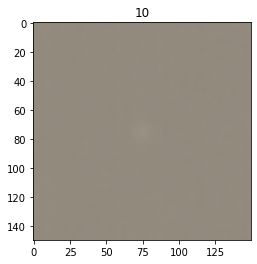

1it [00:00,  7.12it/s]

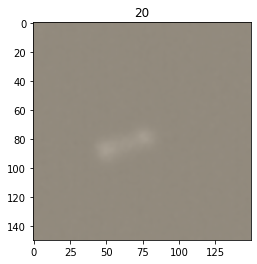

2it [00:00,  7.11it/s]

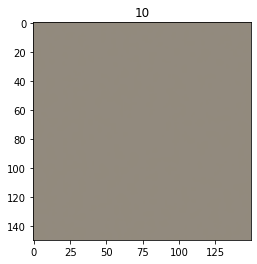

3it [00:00,  7.16it/s]

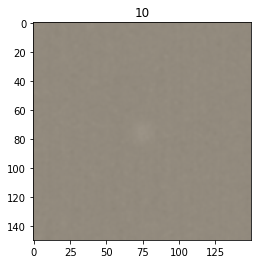

4it [00:00,  7.01it/s]

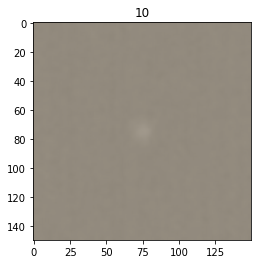

5it [00:00,  6.85it/s]

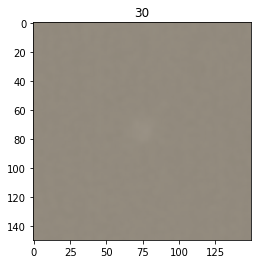

6it [00:00,  6.59it/s]

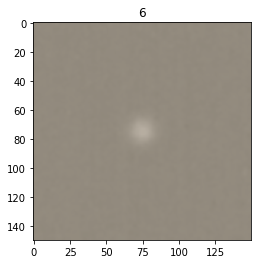

7it [00:01,  6.47it/s]

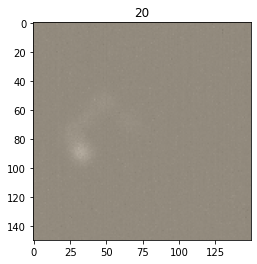

8it [00:01,  6.27it/s]

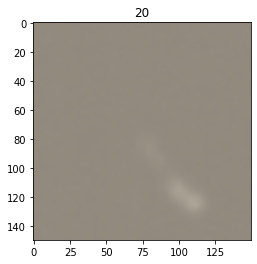

9it [00:01,  6.42it/s]

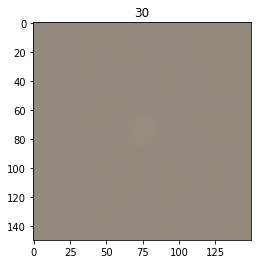

10it [00:01,  6.52it/s]

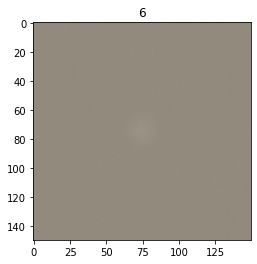

11it [00:01,  5.46it/s]

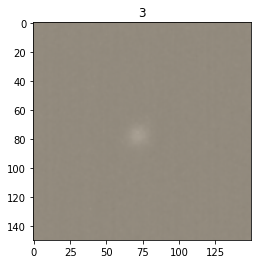

12it [00:01,  5.60it/s]

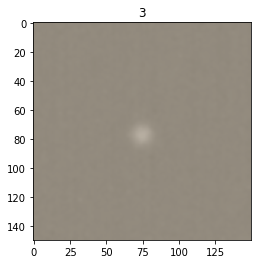

13it [00:02,  5.85it/s]

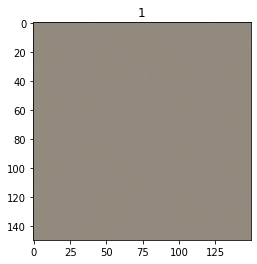

14it [00:02,  6.02it/s]

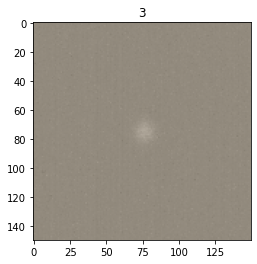

15it [00:02,  6.15it/s]

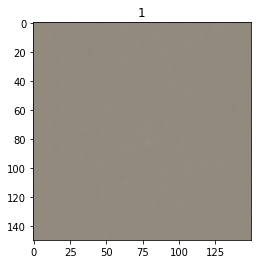

16it [00:02,  6.26it/s]


In [ ]:
class_names = ['1', '3', '6', '10', '20', '30']

def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in tqdm(zip(X_batch, y_batch)):
    show_input(x_item, title=class_names[y_item])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [ ]:
train_dataloader = DataLoader('/content/drive/MyDrive/Colab Notebooks/idao_dataset/energy_train', batch_size=64, shuffle=True)

In [ ]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

ValueError: ignored